In [18]:
"""EDA"""

'EDA'

Processing dataset at C:\\Local Disk (A)\\Github Files\\Projects\\Mass-Sceptra-Classification\\Datasets\\CM1...

Found 28 compounds
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 2
Processing same-compound comparisons for compound 3
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 5
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 7
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 9
Processing same-compound comparisons for compound 10
Processing same-compound comparisons for compound 11
Processing same-compound comparisons for compound 12
Processing same-compound comparisons for compound 13
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 15
Processing same-compound comparisons for compound 16
Processing same-compound comp

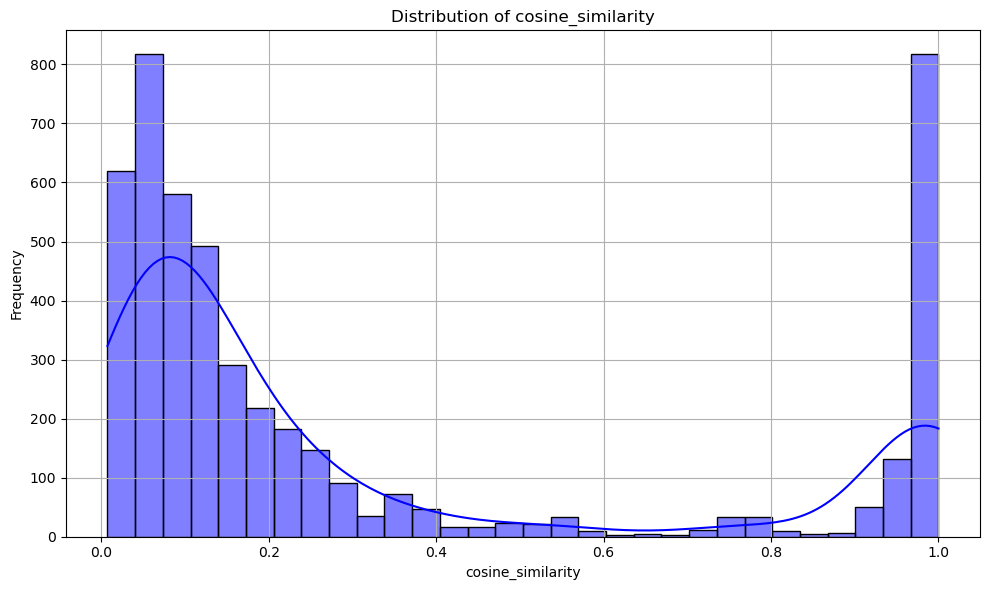

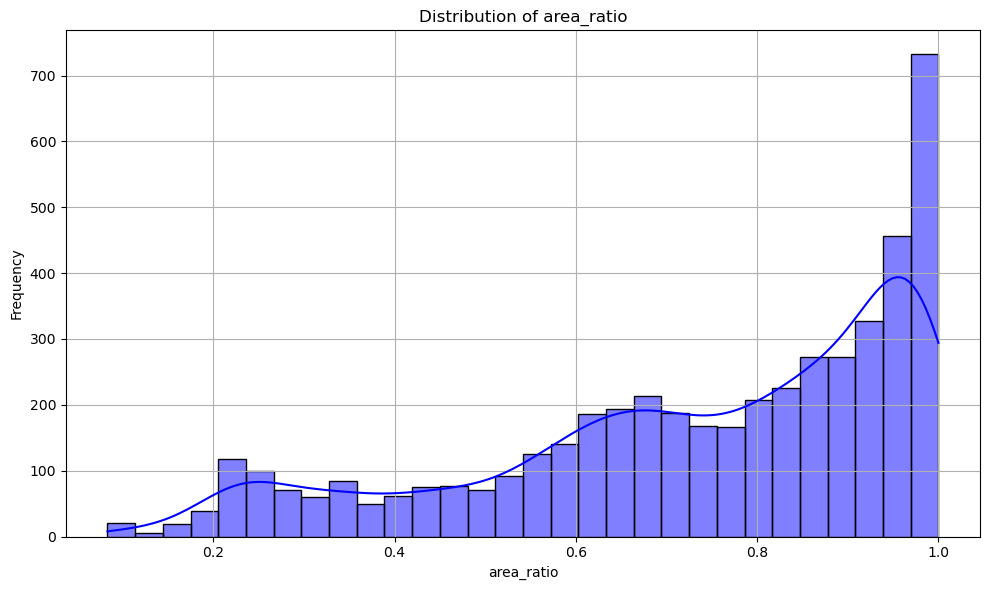

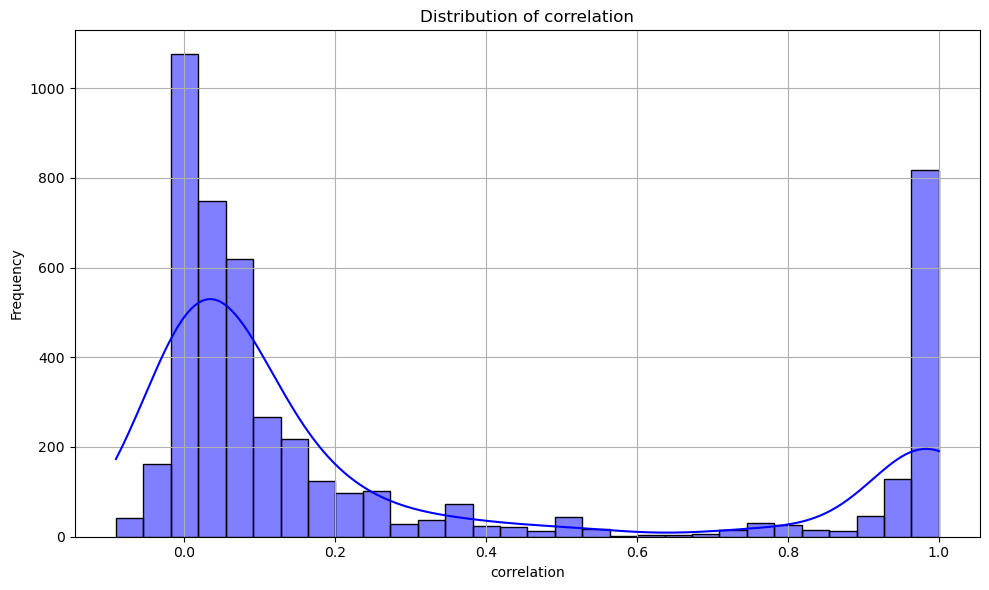

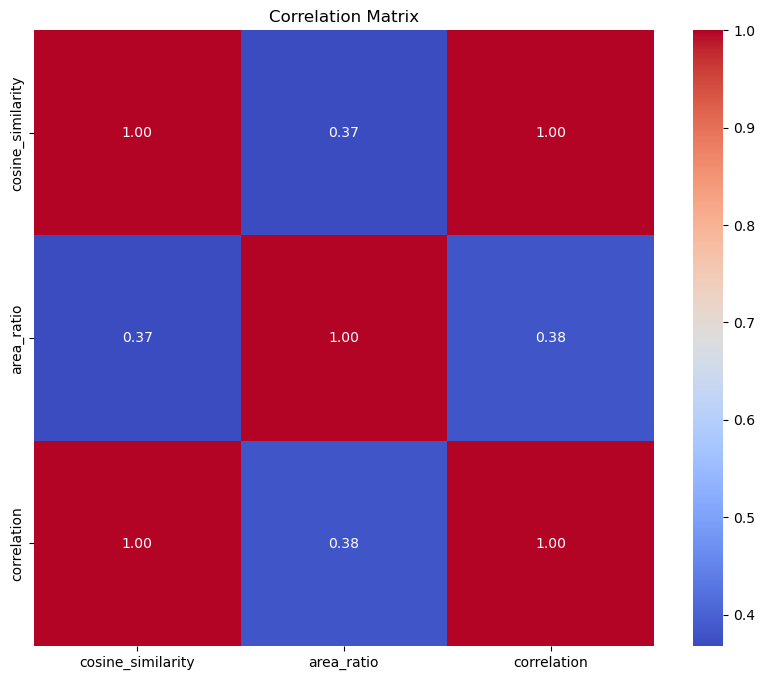

In [23]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import global_functions_morefeatures as gf  # Assuming your imported file

sys.path.append(r"C:\\Local Disk (A)\\Github Files\\Projects\\Mass-Sceptra-Classification\\Visualization\\With more features")

# Dataset combination function without std_ratio
def combine_datasets_with_features(dataset_paths):
    """Combines multiple datasets into one and adds additional features."""
    X_combined, y_combined = [], []
    correlations = []

    for path in dataset_paths:
        print(f"Processing dataset at {path}...")
        X, y, comparisons = gf.generate_balanced_comparisons(path, debug=True)  # Generate features and labels
        if X is not None:
            # Calculate correlation for each pair
            for (file1, file2) in comparisons:
                mz1, int1 = gf.load_spectrum(file1)
                mz2, int2 = gf.load_spectrum(file2)
                _, aligned_int1, aligned_int2 = gf.align_spectra(mz1, int1, mz2, int2)
                
                if aligned_int1 is not None and aligned_int2 is not None:
                    correlation, _ = pearsonr(aligned_int1, aligned_int2)
                    correlations.append(correlation)
                else:
                    correlations.append(0)  # Handle cases where alignment fails
            
            # Append only 'cosine_similarity' and 'area_ratio' features (first two columns)
            X_combined.append(X[:, :2])
            y_combined.append(y)
    
    # Combine all datasets
    if X_combined and y_combined:
        X_combined = np.vstack(X_combined)
        y_combined = np.concatenate(y_combined)
        combined_df = pd.DataFrame(X_combined, columns=['cosine_similarity', 'area_ratio'])
        combined_df['correlation'] = correlations
        combined_df['label'] = y_combined
        return combined_df
    else:
        print("No data generated from the datasets. Exiting...")
        return None

# Statistical Summary Analysis
def statistical_summary(df, features):
    """Prints statistical summary for each feature."""
    print("\nStatistical Summary:")
    summary = df[features].describe().T
    summary['variance'] = df[features].var()
    print(summary)
    return summary

# Outlier Detection
def detect_outliers(df, features):
    """Detects and prints outliers using the IQR method."""
    outliers = {}
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[feature] = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        print(f"\nOutliers for {feature}:")
        print(outliers[feature])
    return outliers

# EDA Functions
def plot_feature_distributions(df, features):
    """Plots the distribution of each feature."""
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[feature], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_correlation_matrix(df, features):
    """Plots the correlation matrix of selected features."""
    corr_matrix = df[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Main Execution
if __name__ == "__main__":
    dataset_paths = [
        r"C:\\Local Disk (A)\\Github Files\\Projects\\Mass-Sceptra-Classification\\Datasets\\CM1",
        r"C:\\Local Disk (A)\\Github Files\\Projects\\Mass-Sceptra-Classification\\Datasets\\CM2",
        r"C:\\Local Disk (A)\\Github Files\\Projects\\Mass-Sceptra-Classification\\Datasets\\CM3"
    ]
    
    # Combine datasets and add features
    combined_df = combine_datasets_with_features(dataset_paths)
    
    if combined_df is not None:
        # Perform Statistical Summary Analysis
        feature_cols = ['cosine_similarity', 'area_ratio', 'correlation']
        summary = statistical_summary(combined_df, feature_cols)
        
        # Detect Outliers
        outliers = detect_outliers(combined_df, feature_cols)
        
        # Perform EDA
        plot_feature_distributions(combined_df, feature_cols)
        plot_correlation_matrix(combined_df, feature_cols)
        
        # Save combined dataset for further use
        combined_df.to_csv("combined_dataset_with_features.csv", index=False)

